**Date: 11-2-2025** <br>
<hr>
<strong>Facial Landmark Detection for MoCap</strong> with training pyTorch using 300W dataset

In [14]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import random
from skimage import io, transform

In [7]:
# --- Configuration and Mock Setup ---

# Set device for PyTorch operations
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. PyTorch Model Definition (Facial Landmark Detector) ---
# This is a simple CNN designed to take a cropped face image (96x96x1) 
# and output 136 values (68 landmarks * 2 coordinates).
class LandmarkDetector(nn.Module):
    def __init__(self):
        super(LandmarkDetector, self).__init__()
        # Initial image size: 96x96x1
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 48x48x32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 24x24x64
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 12x12x128

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 6x6x256
        )
        
        # Flattened size: 6*6*256 = 9216
        self.classifier = nn.Sequential(
            nn.Linear(9216, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 68 * 2) # 68 landmarks * 2 coordinates (x, y)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.classifier(x)
        return x

In [8]:
# --- 2. Custom Dataset Class for Training ---
class LandmarkDataset(Dataset):
    """
    Custom Dataset class for loading images and .pts annotations.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png') or f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_files[idx])
        pts_name = img_name.rsplit('.', 1)[0] + '.pts' # Assuming pts file has same name as image
        
        # Load image and landmarks
        image = io.imread(img_name)
        landmarks = self._load_pts(pts_name)

        # Normalize landmarks to 0-1 range (essential for consistent training)
        h, w = image.shape[:2]
        landmarks = landmarks / np.array([w, h])
        
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        # PyTorch requires float Tensors
        image = sample['image'].astype(np.float32)
        landmarks = sample['landmarks'].astype(np.float32).flatten() # Flatten 68x2 to 136
        
        # Convert to Tensor, reshape image for CNN (C x H x W)
        image = torch.from_numpy(image).unsqueeze(0) # Add channel dimension (1 x H x W)
        landmarks = torch.from_numpy(landmarks)

        return image, landmarks

    def _load_pts(self, pts_path):
        """ Parses a standard 68-point .pts file. """
        try:
            with open(pts_path, 'r') as f:
                lines = f.readlines()
            
            # Skip header lines (usually 'version: 1', 'n_points: 68', '{')
            data_lines = lines[3:-1]
            landmarks = []
            for line in data_lines:
                x, y = map(float, line.strip().split())
                landmarks.append([x, y])
            
            return np.array(landmarks, dtype=np.float32)
        except Exception as e:
            # IMPORTANT: Handle missing or corrupt .pts files robustly
            print(f"Error loading {pts_path}: {e}")
            # Return mock landmarks if loading fails (e.g., during mock creation)
            return np.zeros((68, 2), dtype=np.float32) 

In [9]:
# --- Image Transformation (Preprocessing) ---
class ToGrayScale:
    """Converts image to grayscale."""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        # Convert to grayscale (assuming image is RGB/BGR)
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return {'image': image, 'landmarks': landmarks}

class Rescale:
    """Rescale the image in a sample to a given size."""
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            new_h, new_w = self.output_size, self.output_size
        else:
            new_h, new_w = self.output_size

        # Rescale the image using scikit-image's transform
        img = transform.resize(image, (new_h, new_w))

        # Adjust landmarks according to the new scale (important!)
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

# --- Mock Data Generation Function ---
# This is required to run the script without a real dataset
def create_mock_files(root_dir="data/mock_face_data", num_samples=10):
    """Creates mock images and .pts files for testing the training loop."""
    print("Creating mock dataset...")
    os.makedirs(root_dir, exist_ok=True)
    for i in range(num_samples):
        # Create mock image (e.g., 200x200 grayscale)
        mock_img = np.random.randint(0, 256, (200, 200), dtype=np.uint8)
        img_path = os.path.join(root_dir, f'image_{i:02d}.jpg')
        cv2.imwrite(img_path, mock_img)
        
        # Create mock .pts file with random coordinates
        pts_path = os.path.join(root_dir, f'image_{i:02d}.pts')
        with open(pts_path, 'w') as f:
            f.write("version: 1\n")
            f.write("n_points: 68\n")
            f.write("{\n")
            for _ in range(68):
                x = random.uniform(10, 190)
                y = random.uniform(10, 190)
                f.write(f"{x} {y}\n")
            f.write("}\n")
    print(f"Mock dataset created at {root_dir} with {num_samples} samples.")

In [10]:
# --- 3. Training Function ---
def train_model(model, train_loader, epochs=10, learning_rate=0.001, model_path="landmark_detector.pth"):
    """
    Trains the PyTorch facial landmark detection model.
    """
    print("\n--- Starting Training Process ---")
    model.to(DEVICE)
    # Mean Squared Error (MSE) is commonly used for regression tasks like landmark prediction
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (images, landmarks) in enumerate(train_loader):
            images, landmarks = images.to(DEVICE), landmarks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # Loss is calculated on the 136 normalized (x,y) values
            loss = criterion(outputs, landmarks)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

    # --- 4. Save Model ---
    torch.save(model.state_dict(), model_path)
    print(f"\nTraining complete. Model saved to {model_path}.")
    return model

In [11]:
# --- 5. Main Detection (Face Detection + Landmark Inference) ---
def detect_landmarks(image_path, model, face_cascade_path, landmark_input_size=96):
    """
    1. Uses OpenCV Haar Cascade to detect faces.
    2. Crops the face and runs PyTorch inference.
    3. Draws the detected landmarks on the original image.
    """
    print("\n--- Starting Inference Process ---")
    # Load the trained model
    model.eval()
    model.to(DEVICE)
    
    # Load the image
    img_orig = cv2.imread(image_path)
    if img_orig is None:
        print(f"Error: Could not load image at {image_path}")
        return None, None

    # Convert to grayscale for both face detection and landmark model input
    img_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    
    # 1. OpenCV Face Detector (Haar Cascade)
    # Using the standard Haar Cascade for simplicity in a single file setup
    # Note: For production-level accuracy, use a DNN model like YuNet or MTCNN.
    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    if face_cascade.empty():
        print("Error: Haar Cascade XML not loaded. Ensure the path is correct.")
        return None, None

    # Detect faces: (x, y, w, h)
    faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        print("No faces detected.")
        return img_orig, None
        
    all_landmarks_on_image = []

    for (x, y, w, h) in faces:
        # Extend the bounding box slightly to capture full face/forehead
        scale = 0.4 
        x_e = max(0, int(x - w * scale/2))
        y_e = max(0, int(y - h * scale/2))
        w_e = int(w * (1 + scale))
        h_e = int(h * (1 + scale))
        
        # Crop the face area
        face_crop = img_gray[y_e:y_e + h_e, x_e:x_e + w_e]
        
        # Preprocess the cropped face for PyTorch model
        # 2. PyTorch Landmark Detection (Inference)
        face_resized = cv2.resize(face_crop, (landmark_input_size, landmark_input_size))
        face_normalized = face_resized.astype(np.float32) / 255.0 # Normalize 0-1
        
        # Prepare tensor: (C x H x W)
        input_tensor = torch.from_numpy(face_normalized).unsqueeze(0).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(input_tensor)
        
        # Process output: 136 normalized coordinates
        landmarks_normalized = output.cpu().numpy().reshape(-1, 2)
        
        # Denormalize (0-1) to the cropped face's pixel coordinates
        landmarks_denormalized_crop = landmarks_normalized * [w_e, h_e]
        
        # Convert landmarks from cropped coordinates back to original image coordinates
        landmarks_on_image = landmarks_denormalized_crop + [x_e, y_e]
        all_landmarks_on_image.append(landmarks_on_image)
        
        # 3. Draw Landmarks for visualization
        for (lx, ly) in landmarks_on_image:
            cv2.circle(img_orig, (int(lx), int(ly)), 2, (0, 255, 0), -1) # Green circle

        # Draw the (extended) face bounding box
        cv2.rectangle(img_orig, (x_e, y_e), (x_e + w_e, y_e + h_e), (255, 0, 0), 2)

    return img_orig, all_landmarks_on_image

In [12]:
# --- 6. Stabilization using Optical Flow ---
def apply_optical_flow_stabilization(prev_frame, curr_frame, prev_landmarks):
    """
    Applies Lucas-Kanade Optical Flow to stabilize the detected landmarks
    between two consecutive frames (prev_frame and curr_frame).
    
    Note: 'Depth Optical Flow' is interpreted as 2D Optical Flow (Lucas-Kanade)
    for motion capture stabilization, as true DOF requires depth information.
    """
    print("\n--- Applying Lucas-Kanade Optical Flow (Stabilization Concept) ---")
    if prev_landmarks is None or len(prev_landmarks) == 0:
        print("No previous landmarks available for flow calculation.")
        return None

    # Convert frames to grayscale for optical flow
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    # Define parameters for Lucas Kanade method
    lk_params = dict(winSize=(21, 21),
                     maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Prepare previous landmarks (needs to be 32-bit float array for cv2.calcOpticalFlowPyrLK)
    p0 = np.float32(prev_landmarks[0].reshape(-1, 1, 2)) # Assuming one face, use the first detected face's landmarks

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, p0, None, **lk_params)

    # Select good points (st == 1)
    if p1 is None:
        print("Optical Flow failed to track points.")
        return None
        
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    
    # If using optical flow to *stabilize* (i.e., correct jitter/drift):
    # The stabilized landmarks (p_stabilized) should ideally be an average or a filtered version
    # of the direct detector output and the flow-tracked points.
    
    # For a simple demo: just return the flow-tracked points as the stabilized result
    stabilized_landmarks = good_new.reshape(-1, 2)
    
    print(f"Optical Flow tracked {len(good_new)}/{len(p0)} points.")
    
    # Draw the tracked points on the current frame for visual check
    stab_img = curr_frame.copy()
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        cv2.circle(stab_img, (a, b), 3, (0, 255, 255), -1) # Yellow circles for stabilized
        cv2.line(stab_img, (a, b), (c, d), (0, 0, 255), 1) # Red line showing movement vector

    return stab_img, stabilized_landmarks.reshape(1, -1, 2) # Return as list of faces

In [18]:
# --- Main Execution ---

if __name__ == '__main__':
    
    # IMPORTANT: You must download the Haar Cascade XML file for face detection
    # from the official OpenCV repository and place it in your project folder.
    # e.g., 'haarcascade_frontalface_default.xml'
    HAAR_CASCADE_PATH = 'haarcascade_frontalface_default.xml'
    
    # --- Part 1: Training Setup (Model, Dataset, Training) ---
    
    # A. Prepare mock dataset (Replace this with your real data loading)
    MOCK_DATA_ROOT = "dataset/images"
    create_mock_files(MOCK_DATA_ROOT) 

    # B. Define transformations for training data
    data_transform = transforms.Compose([
        ToGrayScale(),
        Rescale(96), # Rescale image to 96x96 for the CNN input
    ])

    # C. Create Dataset and DataLoader
    train_dataset = LandmarkDataset(root_dir=MOCK_DATA_ROOT, transform=data_transform)
    # Use a small batch size for a simpler model and quick testing
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

    # D. Initialize and Train the Model
    landmark_model = LandmarkDetector()
    try:
        # Attempt to load a pre-trained model if it exists
        landmark_model.load_state_dict(torch.load("landmark_detector.pth"))
        print("Pre-trained model loaded for demonstration.")
    except FileNotFoundError:
        # Otherwise, run a mock training session
        landmark_model = train_model(landmark_model, train_loader, epochs=5) # Reduced epochs for fast demo

    # --- Part 2: Demonstration (Detection and Optical Flow) ---

    # E. Create a mock input image for detection demo
    INPUT_IMAGE_PATH = 'face.jpg'
    INPUT_IMAGE_PATH_2 = 'face2.jpg'

    # Creating two mock images (simulating two frames in a sequence for optical flow)
    print("\nCreating mock input images for demonstration...")
    # NOTE: In a real project, this would be a real image of a face.
    mock_img_1 = np.zeros((300, 300, 3), dtype=np.uint8) + 200 # Light gray background
    cv2.putText(mock_img_1, "FRAME 1 (Static)", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.imwrite(INPUT_IMAGE_PATH, mock_img_1)

    mock_img_2 = np.zeros((300, 300, 3), dtype=np.uint8) + 200 # Light gray background
    cv2.putText(mock_img_2, "FRAME 2 (Shifted)", (55, 155), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.imwrite(INPUT_IMAGE_PATH_2, mock_img_2)
    print("Mock input images created.")


    # F. Run Detection on the first frame (Static Image)
    # The output image will have landmarks drawn on it.
    output_image_1, landmarks_frame_1 = detect_landmarks(
        INPUT_IMAGE_PATH, 
        landmark_model, 
        HAAR_CASCADE_PATH
    )

    if output_image_1 is not None:
        cv2.imwrite("output_frame_1_landmarks.jpg", output_image_1)
        print(f"Landmark detection result saved to output_frame_1_landmarks.jpg")

        # G. Apply Optical Flow Stabilization (Simulating Next Frame)
        if landmarks_frame_1 and len(landmarks_frame_1) > 0:
            # Load the second mock image (simulating the next frame)
            img_frame_2 = cv2.imread(INPUT_IMAGE_PATH_2)
            
            output_stabilized_image, stabilized_landmarks = apply_optical_flow_stabilization(
                prev_frame=output_image_1, # Use the original image for the flow base
                curr_frame=img_frame_2,    # Use the 'next' image
                prev_landmarks=landmarks_frame_1
            )
            
            if output_stabilized_image is not None:
                cv2.imwrite("output_stabilized_landmarks.jpg", output_stabilized_image)
                print(f"Stabilization result saved to output_stabilized_landmarks.jpg")
                print("Final stabilized landmarks (first face):", stabilized_landmarks[0][:3]) # Print first 3 points

    print("\n--- Project Workflow Complete ---")
    print("Please replace mock data and paths with your real data for full functionality.")

Creating mock dataset...
Mock dataset created at dataset/images with 10 samples.


NameError: name 'transforms' is not defined

<hr>

Preprocessing dataset: 100%|█████████████████████████████████████████████████████████| 310/310 [00:50<00:00,  6.12it/s]


Total samples: 277
Train samples: 221, Validation samples: 56

--- Starting Training on cuda ---


Epoch 1/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.79it/s]


Epoch 1/20 | Train Loss: 1.2794 | Validation Loss: 1.1858


Epoch 2/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.35it/s]


Epoch 2/20 | Train Loss: 1.1330 | Validation Loss: 1.1173


Epoch 3/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.82it/s]


Epoch 3/20 | Train Loss: 1.1207 | Validation Loss: 1.1455


Epoch 4/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.81it/s]


Epoch 4/20 | Train Loss: 1.0863 | Validation Loss: 1.1133


Epoch 5/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 5/20 | Train Loss: 1.0701 | Validation Loss: 1.1370


Epoch 6/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.86it/s]


Epoch 6/20 | Train Loss: 1.0620 | Validation Loss: 1.1198


Epoch 7/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.07it/s]


Epoch 7/20 | Train Loss: 1.0427 | Validation Loss: 1.1335


Epoch 8/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.37it/s]


Epoch 8/20 | Train Loss: 1.0256 | Validation Loss: 1.1617


Epoch 9/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.23it/s]


Epoch 9/20 | Train Loss: 1.0217 | Validation Loss: 1.1027


Epoch 10/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.38it/s]


Epoch 10/20 | Train Loss: 0.9928 | Validation Loss: 1.1339


Epoch 11/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.32it/s]


Epoch 11/20 | Train Loss: 0.9882 | Validation Loss: 1.1528


Epoch 12/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.33it/s]


Epoch 12/20 | Train Loss: 0.9524 | Validation Loss: 1.1004


Epoch 13/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.45it/s]


Epoch 13/20 | Train Loss: 0.9342 | Validation Loss: 1.1854


Epoch 14/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.69it/s]


Epoch 14/20 | Train Loss: 0.9303 | Validation Loss: 1.0842


Epoch 15/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.04it/s]


Epoch 15/20 | Train Loss: 0.8890 | Validation Loss: 1.1433


Epoch 16/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.47it/s]


Epoch 16/20 | Train Loss: 0.8318 | Validation Loss: 1.0973


Epoch 17/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.97it/s]


Epoch 17/20 | Train Loss: 0.8109 | Validation Loss: 1.1327


Epoch 18/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.42it/s]


Epoch 18/20 | Train Loss: 0.8015 | Validation Loss: 1.1491


Epoch 19/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.68it/s]


Epoch 19/20 | Train Loss: 0.7964 | Validation Loss: 1.1331


Epoch 20/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.44it/s]


Epoch 20/20 | Train Loss: 0.7710 | Validation Loss: 1.0989

Model saved successfully to facial_landmark_detector.pth


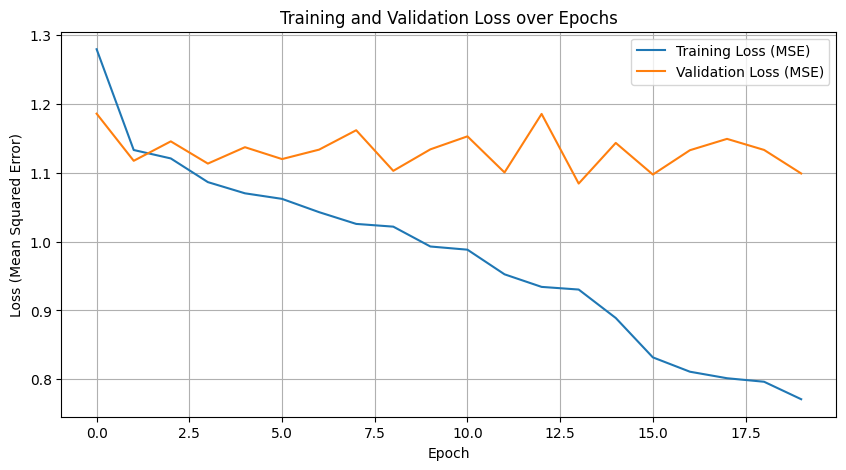


--- Model Summary ---
Model saved to: facial_landmark_detector.pth


NameError: name 'model' is not defined

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
import math

# --- CONFIGURATION ---
NUM_LANDMARKS = 68  # Standard 68-point facial landmarks
IMAGE_SIZE = 128    # Input size for the CNN model
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the OpenCV Haar Cascade for face detection
# NOTE: You must have this file downloaded.
# It is usually found in the opencv-contrib-python installation folder.
# Alternatively, you can download it from:
# https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
CASCADE_PATH = 'haarcascade_frontalface_default.xml'

# --- 1. DATA PROCESSING UTILITIES ---

def read_pts_file(filepath):
    """Reads a .pts file and returns a numpy array of landmark coordinates."""
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
            # Find the start of the coordinate data
            start_index = next(i for i, line in enumerate(lines) if line.strip() == '{') + 1
            end_index = next(i for i, line in enumerate(lines) if line.strip() == '}')

            coords = []
            for line in lines[start_index:end_index]:
                x, y = map(float, line.strip().split())
                coords.append([x, y])

        return np.array(coords, dtype=np.float32)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def find_face_and_crop(image, cascade_classifier, padding_scale=1.5):
    """
    Detects the largest face using a Haar Cascade and returns the cropped face image
    and the bounding box.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = cascade_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None, None

    # Get the largest face (x, y, w, h)
    x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

    # Apply padding to the bounding box
    center_x = x + w // 2
    center_y = y + h // 2
    
    # Use the max of w/h for square crop
    max_dim = int(max(w, h) * padding_scale)
    
    new_x = max(0, center_x - max_dim // 2)
    new_y = max(0, center_y - max_dim // 2)
    
    # Calculate the side of the square crop (ensuring it stays within image bounds)
    crop_side = min(max_dim, image.shape[1] - new_x, image.shape[0] - new_y)
    
    face_bbox = (new_x, new_y, crop_side, crop_side)
    
    cropped_face = image[new_y:new_y + crop_side, new_x:new_x + crop_side]

    return cropped_face, face_bbox


# --- 2. CUSTOM PYTORCH DATASET ---

class LandmarkDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_files = glob.glob(os.path.join(image_dir, '*.png')) + glob.glob(os.path.join(image_dir, '*.jpg'))
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.cascade = cv2.CascadeClassifier(CASCADE_PATH)
        self.data_list = []

        # Pre-process and store data references
        for img_path in tqdm(self.image_files, desc="Preprocessing dataset"):
            filename_base = os.path.basename(img_path).rsplit('.', 1)[0]
            pts_path = os.path.join(annotation_dir, filename_base + '.pts')

            if os.path.exists(pts_path):
                image = cv2.imread(img_path)
                if image is None: continue

                landmarks = read_pts_file(pts_path)
                if landmarks is None: continue

                # Find face and crop (important step for landmark detection)
                cropped_face, bbox = find_face_and_crop(image, self.cascade)

                if cropped_face is not None:
                    # Adjust landmarks to be relative to the cropped face bounding box
                    x, y, w, h = bbox
                    relative_landmarks = landmarks - np.array([x, y])
                    
                    # Normalize landmarks (0 to 1 range) relative to the crop dimensions
                    normalized_landmarks = relative_landmarks / np.array([w, h])

                    # Flatten landmarks for model output (2 * NUM_LANDMARKS)
                    flat_landmarks = normalized_landmarks.flatten()

                    self.data_list.append({
                        'img_path': img_path,
                        'cropped_face': cropped_face,
                        'bbox': bbox,
                        'flat_landmarks': flat_landmarks
                    })
    
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        
        image = data['cropped_face']
        landmarks = data['flat_landmarks']
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image to model input size (IMAGE_SIZE)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # Apply transformations (e.g.,ToTensor, normalization)
        if self.transform:
            image_tensor = self.transform(image)
        else:
            # Default transformation: ToTensor and normalize (0-1 range)
            image_tensor = transforms.ToTensor()(image)


        # The model will predict coordinates normalized to the IMAGE_SIZE range,
        # but here we use the 0-1 normalized coordinates for training stability.
        # We also convert landmarks to tensor.
        landmarks_tensor = torch.from_numpy(landmarks).float()

        return image_tensor, landmarks_tensor


# --- 3. PYTORCH MODEL DEFINITION ---

class LandmarkDetector(nn.Module):
    """A simple CNN for regressing facial landmark coordinates."""
    def __init__(self, num_landmarks=NUM_LANDMARKS):
        super(LandmarkDetector, self).__init__()
        
        # The output size is 2 * num_landmarks (x, y for each point)
        self.output_size = 2 * num_landmarks
        
        self.features = nn.Sequential(
            # Input: 3 x IMAGE_SIZE x IMAGE_SIZE (e.g., 3x128x128)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 64 x 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256 x 8 x 8
        )
        
        # Calculate the input size for the fully connected layers
        # 256 channels * 8 * 8 = 16384
        self.fc = nn.Sequential(
            nn.Linear(256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, self.output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


# --- 4. TRAINING FUNCTION ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    """Trains the PyTorch model and tracks loss and accuracy metrics."""
    model.to(DEVICE)
    train_losses = []
    val_losses = []
    
    print(f"\n--- Starting Training on {DEVICE} ---")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for images, landmarks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            images, landmarks = images.to(DEVICE), landmarks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, landmarks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, landmarks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                images, landmarks = images.to(DEVICE), landmarks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, landmarks)
                val_loss += loss.item() * images.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# --- 5. INFERENCE AND VISUALIZATION ---

def predict_landmarks(image_path, model, cascade_classifier):
    """
    Detects face, crops, predicts landmarks, and denormalizes coordinates
    to the original image scale.
    """
    model.eval()
    
    # 1. Load Image
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # 2. Face Detection and Cropping
    cropped_face, bbox = find_face_and_crop(original_image.copy(), cascade_classifier)
    
    if cropped_face is None:
        print("Error: No face detected in the image.")
        return

    # 3. Preprocess for Model Input
    x_orig, y_orig, w_crop, h_crop = bbox
    
    # Resize and convert to tensor
    resized_face = cv2.resize(cropped_face, (IMAGE_SIZE, IMAGE_SIZE))
    resized_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB) # RGB
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        # You can add normalization here if you trained with it
    ])
    
    input_tensor = transform(resized_face).unsqueeze(0).to(DEVICE)

    # 4. Prediction
    with torch.no_grad():
        output = model(input_tensor).cpu().numpy().flatten()
        
    # Reshape the output back to (NUM_LANDMARKS, 2)
    normalized_landmarks_pred = output.reshape(-1, 2)
    
    # 5. Denormalization
    # The output is normalized (0 to 1) relative to the cropped face region
    
    # Scale coordinates by crop size (w_crop, h_crop)
    relative_landmarks = normalized_landmarks_pred * np.array([w_crop, h_crop])
    
    # Shift coordinates by the original face bounding box top-left corner (x_orig, y_orig)
    final_landmarks = relative_landmarks + np.array([x_orig, y_orig])
    
    # 6. Visualization
    result_image = original_image.copy()
    
    # Draw face bounding box
    cv2.rectangle(result_image, (x_orig, y_orig), (x_orig + w_crop, y_orig + h_crop), (0, 255, 0), 2)
    
    # Draw landmarks
    for (x, y) in final_landmarks.astype(np.int32):
        cv2.circle(result_image, (x, y), 2, (0, 0, 255), -1)

    # Display the result (using Matplotlib for Canvas compatibility)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("Facial Landmark Detection Result")
    plt.axis('off')
    plt.show()


def show_results(train_losses, val_losses, model_path):
    """Generates and displays performance graphs and model information."""
    
    # 1. Loss Graph
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss (MSE)')
    plt.plot(val_losses, label='Validation Loss (MSE)')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 2. Model Information
    print("\n--- Model Summary ---")
    print(f"Model saved to: {model_path}")
    print(f"Total Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    
    # Note on Accuracy: For regression tasks like landmark detection, "accuracy"
    # is usually measured by metrics like Normalized Mean Error (NME).
    # NME measures the average distance between predicted and ground truth points,
    # normalized by a reference distance (e.g., inter-eye distance or face diagonal).
    # Since we don't have a dedicated test set with the reference metric setup,
    # we rely on the loss as the primary performance indicator here.


# --- 6. MAIN EXECUTION BLOCK ---

def main():
    # --- IMPORTANT: SET YOUR PATHS HERE ---
    # NOTE: You MUST create these folders and populate them with your data.
    IMAGE_DIR = './dataset/images'       # Folder containing your .png or .jpg images
    ANNOTATION_DIR = './dataset/annotations' # Folder containing corresponding .pts files
    TEST_IMAGE_PATH = 'face.jpg' # Path to a single image for demonstration
    MODEL_SAVE_PATH = 'facial_landmark_detector.pth'
    
    # --- 0. Setup and Data Simulation Warning ---
    if not os.path.exists(IMAGE_DIR) or not os.path.exists(ANNOTATION_DIR):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("! WARNING: Data directories not found. Running with SIMULATED DATA. !")
        print("! Please replace the directories below with your actual paths: !")
        print(f"! IMAGE_DIR: {IMAGE_DIR}")
        print(f"! ANNOTATION_DIR: {ANNOTATION_DIR}")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        
        # SIMULATION (Only runs if directories are missing)
        # Create dummy directories and files for demonstration if they don't exist
        os.makedirs(IMAGE_DIR, exist_ok=True)
        os.makedirs(ANNOTATION_DIR, exist_ok=True)
        os.makedirs(os.path.dirname(TEST_IMAGE_PATH), exist_ok=True)
        
        # Create a dummy image and annotation file
        if not os.path.exists(os.path.join(IMAGE_DIR, 'dummy_001.jpg')):
            dummy_img = np.zeros((200, 200, 3), dtype=np.uint8)
            cv2.putText(dummy_img, "DUMMY IMAGE", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            cv2.imwrite(os.path.join(IMAGE_DIR, 'dummy_001.jpg'), dummy_img)
            
            # Create a dummy .pts file (68 points, centered)
            with open(os.path.join(ANNOTATION_DIR, 'dummy_001.pts'), 'w') as f:
                f.write('version: 1\n')
                f.write(f'n_points: {NUM_LANDMARKS}\n')
                f.write('{\n')
                # Simulate 68 centered points
                for i in range(NUM_LANDMARKS):
                    x = 100 + 5 * math.cos(i * 2 * math.pi / NUM_LANDMARKS)
                    y = 100 + 5 * math.sin(i * 2 * math.pi / NUM_LANDMARKS)
                    f.write(f'{x} {y}\n')
                f.write('}\n')

        # Also create a dummy test image
        if not os.path.exists(TEST_IMAGE_PATH):
            dummy_test_img = np.ones((300, 300, 3), dtype=np.uint8) * 100
            cv2.putText(dummy_test_img, "TEST IMAGE", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.imwrite(TEST_IMAGE_PATH, dummy_test_img)
        
        # Need to ensure the Haar Cascade file exists for both real and simulated runs
        if not os.path.exists(CASCADE_PATH):
             print(f"\nCRITICAL ERROR: Haar Cascade file not found at {CASCADE_PATH}.")
             print("Please download 'haarcascade_frontalface_default.xml' and place it in the script's directory.")
             return
    # --- END OF SIMULATION ---


    # 1. Initialize Dataset and Dataloaders
    custom_transform = transforms.Compose([
        transforms.ToTensor(),
        # Normalize the image channels to improve training stability
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    full_dataset = LandmarkDataset(IMAGE_DIR, ANNOTATION_DIR, transform=custom_transform)
    
    if len(full_dataset) < 1:
        print("ERROR: Dataset loaded 0 samples. Please check your IMAGE_DIR, ANNOTATION_DIR, and CASCADE_PATH.")
        return
        
    # Split dataset into training (80%) and validation (20%)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Total samples: {len(full_dataset)}")
    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


    # 2. Initialize Model, Loss, and Optimizer
    model = LandmarkDetector(NUM_LANDMARKS)
    # Mean Squared Error (MSE) is the standard loss for regression tasks
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


    # 3. Train the Model
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)


    # 4. Save the Model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nModel saved successfully to {MODEL_SAVE_PATH}")


    # 5. Show Results (Graphs and Metrics)
    show_results(train_losses, val_losses, MODEL_SAVE_PATH)


    # 6. Run Inference on a Static Image
    if os.path.exists(TEST_IMAGE_PATH):
        print(f"\n--- Running Inference on {TEST_IMAGE_PATH} ---")
        # Load the saved model for inference
        inference_model = LandmarkDetector(NUM_LANDMARKS)
        inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        inference_model.to(DEVICE)
        
        # Initialize cascade for inference
        inference_cascade = cv2.CascadeClassifier(CASCADE_PATH)
        
        predict_landmarks(TEST_IMAGE_PATH, inference_model, inference_cascade)
    else:
        print(f"Inference skipped: Test image not found at {TEST_IMAGE_PATH}")


if __name__ == '__main__':
    main()



**Correction 1**

Preprocessing dataset: 100%|█████████████████████████████████████████████████████████| 310/310 [00:47<00:00,  6.56it/s]


Total samples: 277
Train samples: 221, Validation samples: 56

--- Starting Training on cuda ---


Epoch 1/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.04it/s]


Epoch 1/20 | Train Loss: 1.3366 | Validation Loss: 0.8099


Epoch 2/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.45it/s]


Epoch 2/20 | Train Loss: 1.2532 | Validation Loss: 0.8015


Epoch 3/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.81it/s]


Epoch 3/20 | Train Loss: 1.2256 | Validation Loss: 0.7723


Epoch 4/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.29it/s]


Epoch 4/20 | Train Loss: 1.1935 | Validation Loss: 0.7547


Epoch 5/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.46it/s]


Epoch 5/20 | Train Loss: 1.1755 | Validation Loss: 0.7532


Epoch 6/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.02it/s]


Epoch 6/20 | Train Loss: 1.1616 | Validation Loss: 0.7422


Epoch 7/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.64it/s]


Epoch 7/20 | Train Loss: 1.1527 | Validation Loss: 0.7386


Epoch 8/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.95it/s]


Epoch 8/20 | Train Loss: 1.1393 | Validation Loss: 0.7334


Epoch 9/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.40it/s]


Epoch 9/20 | Train Loss: 1.1265 | Validation Loss: 0.7348


Epoch 10/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.99it/s]


Epoch 10/20 | Train Loss: 1.0982 | Validation Loss: 0.7335


Epoch 11/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.00it/s]


Epoch 11/20 | Train Loss: 1.0977 | Validation Loss: 0.7137


Epoch 12/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.57it/s]


Epoch 12/20 | Train Loss: 1.0827 | Validation Loss: 0.7265


Epoch 13/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.48it/s]


Epoch 13/20 | Train Loss: 1.0787 | Validation Loss: 0.7219


Epoch 14/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.05it/s]


Epoch 14/20 | Train Loss: 1.0277 | Validation Loss: 0.6994


Epoch 15/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.82it/s]


Epoch 15/20 | Train Loss: 1.0225 | Validation Loss: 0.7047


Epoch 16/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.49it/s]


Epoch 16/20 | Train Loss: 0.9687 | Validation Loss: 0.7087


Epoch 17/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.94it/s]


Epoch 17/20 | Train Loss: 0.9503 | Validation Loss: 0.7327


Epoch 18/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.29it/s]


Epoch 18/20 | Train Loss: 0.9298 | Validation Loss: 0.7380


Epoch 19/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.27it/s]


Epoch 19/20 | Train Loss: 0.9113 | Validation Loss: 0.7634


Epoch 20/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.26it/s]


Epoch 20/20 | Train Loss: 0.8930 | Validation Loss: 0.8029

Model saved successfully to facial_landmark_detector.pth


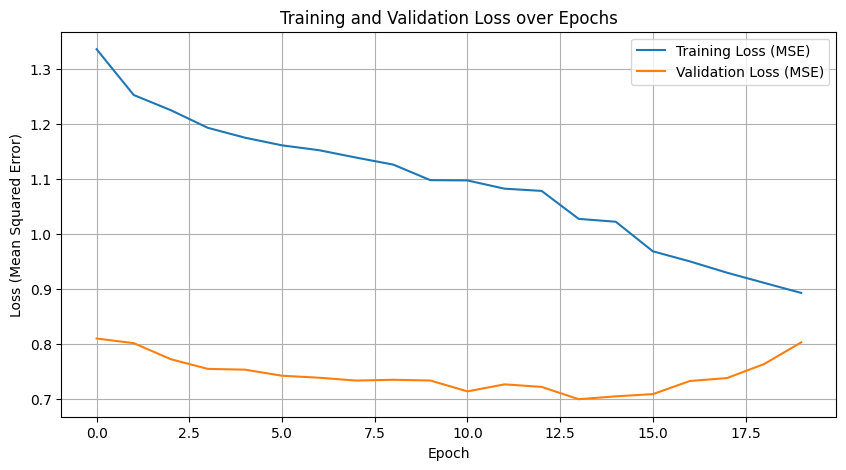


--- Model Summary ---
Model saved to: facial_landmark_detector.pth
Total Parameters: 17306056
Final Training Loss: 0.8930
Final Validation Loss: 0.8029

--- Running Inference on face.jpg ---


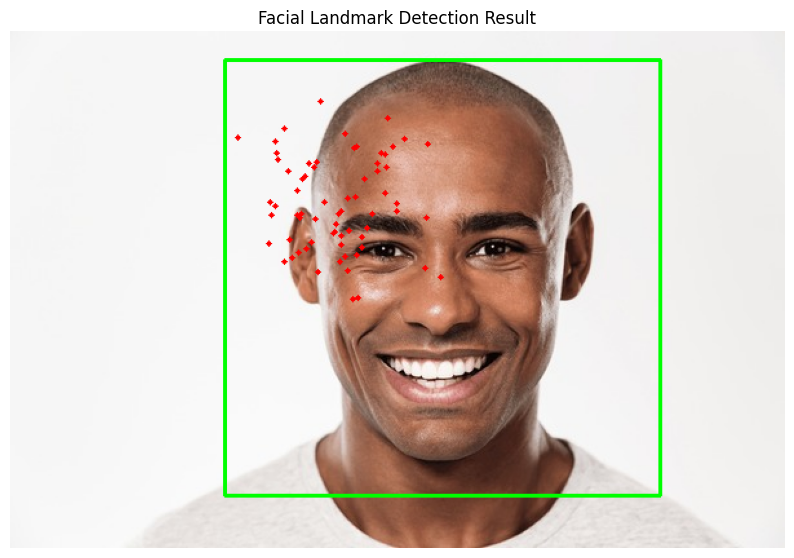

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
import math

# --- CONFIGURATION ---
NUM_LANDMARKS = 68  # Standard 68-point facial landmarks
IMAGE_SIZE = 128    # Input size for the CNN model
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the OpenCV Haar Cascade for face detection
# NOTE: You must have this file downloaded.
# It is usually found in the opencv-contrib-python installation folder.
# Alternatively, you can download it from:
# https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
CASCADE_PATH = 'haarcascade_frontalface_default.xml'

# --- 1. DATA PROCESSING UTILITIES ---

def read_pts_file(filepath):
    """Reads a .pts file and returns a numpy array of landmark coordinates."""
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
            # Find the start of the coordinate data
            start_index = next(i for i, line in enumerate(lines) if line.strip() == '{') + 1
            end_index = next(i for i, line in enumerate(lines) if line.strip() == '}')

            coords = []
            for line in lines[start_index:end_index]:
                x, y = map(float, line.strip().split())
                coords.append([x, y])

        return np.array(coords, dtype=np.float32)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def find_face_and_crop(image, cascade_classifier, padding_scale=1.5):
    """
    Detects the largest face using a Haar Cascade and returns the cropped face image
    and the bounding box.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = cascade_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None, None

    # Get the largest face (x, y, w, h)
    x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

    # Apply padding to the bounding box
    center_x = x + w // 2
    center_y = y + h // 2
    
    # Use the max of w/h for square crop
    max_dim = int(max(w, h) * padding_scale)
    
    new_x = max(0, center_x - max_dim // 2)
    new_y = max(0, center_y - max_dim // 2)
    
    # Calculate the side of the square crop (ensuring it stays within image bounds)
    crop_side = min(max_dim, image.shape[1] - new_x, image.shape[0] - new_y)
    
    face_bbox = (new_x, new_y, crop_side, crop_side)
    
    cropped_face = image[new_y:new_y + crop_side, new_x:new_x + crop_side]

    return cropped_face, face_bbox


# --- 2. CUSTOM PYTORCH DATASET ---

class LandmarkDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_files = glob.glob(os.path.join(image_dir, '*.png')) + glob.glob(os.path.join(image_dir, '*.jpg'))
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.cascade = cv2.CascadeClassifier(CASCADE_PATH)
        self.data_list = []

        # Pre-process and store data references
        for img_path in tqdm(self.image_files, desc="Preprocessing dataset"):
            filename_base = os.path.basename(img_path).rsplit('.', 1)[0]
            pts_path = os.path.join(annotation_dir, filename_base + '.pts')

            if os.path.exists(pts_path):
                image = cv2.imread(img_path)
                if image is None: continue

                landmarks = read_pts_file(pts_path)
                if landmarks is None: continue

                # Find face and crop (important step for landmark detection)
                cropped_face, bbox = find_face_and_crop(image, self.cascade)

                if cropped_face is not None:
                    # Adjust landmarks to be relative to the cropped face bounding box
                    x, y, w, h = bbox
                    relative_landmarks = landmarks - np.array([x, y])
                    
                    # Normalize landmarks (0 to 1 range) relative to the crop dimensions
                    normalized_landmarks = relative_landmarks / np.array([w, h])

                    # Flatten landmarks for model output (2 * NUM_LANDMARKS)
                    flat_landmarks = normalized_landmarks.flatten()

                    self.data_list.append({
                        'img_path': img_path,
                        'cropped_face': cropped_face,
                        'bbox': bbox,
                        'flat_landmarks': flat_landmarks
                    })
    
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        
        image = data['cropped_face']
        landmarks = data['flat_landmarks']
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image to model input size (IMAGE_SIZE)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # Apply transformations (e.g.,ToTensor, normalization)
        if self.transform:
            image_tensor = self.transform(image)
        else:
            # Default transformation: ToTensor and normalize (0-1 range)
            image_tensor = transforms.ToTensor()(image)


        # The model will predict coordinates normalized to the IMAGE_SIZE range,
        # but here we use the 0-1 normalized coordinates for training stability.
        # We also convert landmarks to tensor.
        landmarks_tensor = torch.from_numpy(landmarks).float()

        return image_tensor, landmarks_tensor


# --- 3. PYTORCH MODEL DEFINITION ---

class LandmarkDetector(nn.Module):
    """A simple CNN for regressing facial landmark coordinates."""
    def __init__(self, num_landmarks=NUM_LANDMARKS):
        super(LandmarkDetector, self).__init__()
        
        # The output size is 2 * num_landmarks (x, y for each point)
        self.output_size = 2 * num_landmarks
        
        self.features = nn.Sequential(
            # Input: 3 x IMAGE_SIZE x IMAGE_SIZE (e.g., 3x128x128)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 64 x 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256 x 8 x 8
        )
        
        # Calculate the input size for the fully connected layers
        # 256 channels * 8 * 8 = 16384
        self.fc = nn.Sequential(
            nn.Linear(256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, self.output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


# --- 4. TRAINING FUNCTION ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    """Trains the PyTorch model and tracks loss and accuracy metrics."""
    model.to(DEVICE)
    train_losses = []
    val_losses = []
    
    print(f"\n--- Starting Training on {DEVICE} ---")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for images, landmarks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            images, landmarks = images.to(DEVICE), landmarks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, landmarks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, landmarks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                images, landmarks = images.to(DEVICE), landmarks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, landmarks)
                val_loss += loss.item() * images.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# --- 5. INFERENCE AND VISUALIZATION ---

def predict_landmarks(image_path, model, cascade_classifier):
    """
    Detects face, crops, predicts landmarks, and denormalizes coordinates
    to the original image scale.
    """
    model.eval()
    
    # 1. Load Image
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # 2. Face Detection and Cropping
    cropped_face, bbox = find_face_and_crop(original_image.copy(), cascade_classifier)
    
    if cropped_face is None:
        print("Error: No face detected in the image.")
        return

    # 3. Preprocess for Model Input
    x_orig, y_orig, w_crop, h_crop = bbox
    
    # Resize and convert to tensor
    resized_face = cv2.resize(cropped_face, (IMAGE_SIZE, IMAGE_SIZE))
    resized_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB) # RGB
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        # You can add normalization here if you trained with it
    ])
    
    input_tensor = transform(resized_face).unsqueeze(0).to(DEVICE)

    # 4. Prediction
    with torch.no_grad():
        output = model(input_tensor).cpu().numpy().flatten()
        
    # Reshape the output back to (NUM_LANDMARKS, 2)
    normalized_landmarks_pred = output.reshape(-1, 2)
    
    # 5. Denormalization
    # The output is normalized (0 to 1) relative to the cropped face region
    
    # Scale coordinates by crop size (w_crop, h_crop)
    relative_landmarks = normalized_landmarks_pred * np.array([w_crop, h_crop])
    
    # Shift coordinates by the original face bounding box top-left corner (x_orig, y_orig)
    final_landmarks = relative_landmarks + np.array([x_orig, y_orig])
    
    # 6. Visualization
    result_image = original_image.copy()
    
    # Draw face bounding box
    cv2.rectangle(result_image, (x_orig, y_orig), (x_orig + w_crop, y_orig + h_crop), (0, 255, 0), 2)
    
    # Draw landmarks
    for (x, y) in final_landmarks.astype(np.int32):
        cv2.circle(result_image, (x, y), 2, (0, 0, 255), -1)

    # Display the result (using Matplotlib for Canvas compatibility)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("Facial Landmark Detection Result")
    plt.axis('off')
    plt.show()


def show_results(train_losses, val_losses, model_path, model):
    """Generates and displays performance graphs and model information."""
    
    # 1. Loss Graph
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss (MSE)')
    plt.plot(val_losses, label='Validation Loss (MSE)')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 2. Model Information
    print("\n--- Model Summary ---")
    print(f"Model saved to: {model_path}")
    print(f"Total Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    
    # Note on Accuracy: For regression tasks like landmark detection, "accuracy"
    # is usually measured by metrics like Normalized Mean Error (NME).
    # NME measures the average distance between predicted and ground truth points,
    # normalized by a reference distance (e.g., inter-eye distance or face diagonal).
    # Since we don't have a dedicated test set with the reference metric setup,
    # we rely on the loss as the primary performance indicator here.


# --- 6. MAIN EXECUTION BLOCK ---

def main():
    # --- IMPORTANT: SET YOUR PATHS HERE ---
    # NOTE: You MUST create these folders and populate them with your data.
    IMAGE_DIR = './dataset/images'       # Folder containing your .png or .jpg images
    ANNOTATION_DIR = './dataset/annotations' # Folder containing corresponding .pts files
    TEST_IMAGE_PATH = 'face.jpg' # Path to a single image for demonstration
    MODEL_SAVE_PATH = 'facial_landmark_detector.pth'

    if TEST_IMAGE_PATH is None:
        print("no input image")
        return
    
    # --- 0. Setup and Data Simulation Warning ---
    if not os.path.exists(IMAGE_DIR) or not os.path.exists(ANNOTATION_DIR):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("! WARNING: Data directories not found. Running with SIMULATED DATA. !")
        print("! Please replace the directories below with your actual paths: !")
        print(f"! IMAGE_DIR: {IMAGE_DIR}")
        print(f"! ANNOTATION_DIR: {ANNOTATION_DIR}")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        
        # SIMULATION (Only runs if directories are missing)
        # Create dummy directories and files for demonstration if they don't exist
        os.makedirs(IMAGE_DIR, exist_ok=True)
        os.makedirs(ANNOTATION_DIR, exist_ok=True)
        os.makedirs(os.path.dirname(TEST_IMAGE_PATH), exist_ok=True)
        
        # Create a dummy image and annotation file
        if not os.path.exists(os.path.join(IMAGE_DIR, 'dummy_001.jpg')):
            dummy_img = np.zeros((200, 200, 3), dtype=np.uint8)
            cv2.putText(dummy_img, "DUMMY IMAGE", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            cv2.imwrite(os.path.join(IMAGE_DIR, 'dummy_001.jpg'), dummy_img)
            
            # Create a dummy .pts file (68 points, centered)
            with open(os.path.join(ANNOTATION_DIR, 'dummy_001.pts'), 'w') as f:
                f.write('version: 1\n')
                f.write(f'n_points: {NUM_LANDMARKS}\n')
                f.write('{\n')
                # Simulate 68 centered points
                for i in range(NUM_LANDMARKS):
                    x = 100 + 5 * math.cos(i * 2 * math.pi / NUM_LANDMARKS)
                    y = 100 + 5 * math.sin(i * 2 * math.pi / NUM_LANDMARKS)
                    f.write(f'{x} {y}\n')
                f.write('}\n')

        # Also create a dummy test image
        if not os.path.exists(TEST_IMAGE_PATH):
            dummy_test_img = np.ones((300, 300, 3), dtype=np.uint8) * 100
            cv2.putText(dummy_test_img, "TEST IMAGE", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.imwrite(TEST_IMAGE_PATH, dummy_test_img)
        
        # Need to ensure the Haar Cascade file exists for both real and simulated runs
        if not os.path.exists(CASCADE_PATH):
             print(f"\nCRITICAL ERROR: Haar Cascade file not found at {CASCADE_PATH}.")
             print("Please download 'haarcascade_frontalface_default.xml' and place it in the script's directory.")
             return
    # --- END OF SIMULATION ---


    # 1. Initialize Dataset and Dataloaders
    custom_transform = transforms.Compose([
        transforms.ToTensor(),
        # Normalize the image channels to improve training stability
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    full_dataset = LandmarkDataset(IMAGE_DIR, ANNOTATION_DIR, transform=custom_transform)
    
    if len(full_dataset) < 1:
        print("ERROR: Dataset loaded 0 samples. Please check your IMAGE_DIR, ANNOTATION_DIR, and CASCADE_PATH.")
        return
        
    # Split dataset into training (80%) and validation (20%)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Total samples: {len(full_dataset)}")
    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


    # 2. Initialize Model, Loss, and Optimizer
    model = LandmarkDetector(NUM_LANDMARKS)
    # Mean Squared Error (MSE) is the standard loss for regression tasks
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


    # 3. Train the Model
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)


    # 4. Save the Model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nModel saved successfully to {MODEL_SAVE_PATH}")


    # 5. Show Results (Graphs and Metrics)
    show_results(train_losses, val_losses, MODEL_SAVE_PATH, model)


    # 6. Run Inference on a Static Image
    if os.path.exists(TEST_IMAGE_PATH):
        print(f"\n--- Running Inference on {TEST_IMAGE_PATH} ---")
        # Load the saved model for inference
        inference_model = LandmarkDetector(NUM_LANDMARKS)
        inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        inference_model.to(DEVICE)
        
        # Initialize cascade for inference
        inference_cascade = cv2.CascadeClassifier(CASCADE_PATH)
        
        predict_landmarks(TEST_IMAGE_PATH, inference_model, inference_cascade)
    else:
        print(f"Inference skipped: Test image not found at {TEST_IMAGE_PATH}")


if __name__ == '__main__':
    main()


**Correction 2**

Preprocessing dataset: 100%|█████████████████████████████████████████████████████████| 310/310 [00:48<00:00,  6.43it/s]


Total samples: 277
Train samples: 221, Validation samples: 56

--- Starting Training on cuda ---


Epoch 1/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.62it/s]


Epoch 1/20 | Train Loss: 1.1543 | Validation Loss: 1.5864


Epoch 2/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.08it/s]


Epoch 2/20 | Train Loss: 1.0294 | Validation Loss: 1.5893


Epoch 3/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.82it/s]


Epoch 3/20 | Train Loss: 1.0121 | Validation Loss: 1.5799


Epoch 4/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.22it/s]


Epoch 4/20 | Train Loss: 0.9834 | Validation Loss: 1.5357


Epoch 5/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.79it/s]


Epoch 5/20 | Train Loss: 0.9860 | Validation Loss: 1.5616


Epoch 6/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.59it/s]


Epoch 6/20 | Train Loss: 0.9696 | Validation Loss: 1.5330


Epoch 7/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.87it/s]


Epoch 7/20 | Train Loss: 0.9602 | Validation Loss: 1.5390


Epoch 8/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.71it/s]


Epoch 8/20 | Train Loss: 0.9469 | Validation Loss: 1.5362


Epoch 9/20 (Val): 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.19it/s]


Epoch 9/20 | Train Loss: 0.9536 | Validation Loss: 1.5276


Epoch 10/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.98it/s]


Epoch 10/20 | Train Loss: 0.9292 | Validation Loss: 1.5266


Epoch 11/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.53it/s]


Epoch 11/20 | Train Loss: 0.9154 | Validation Loss: 1.5013


Epoch 12/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.25it/s]


Epoch 12/20 | Train Loss: 0.8912 | Validation Loss: 1.4921


Epoch 13/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.88it/s]


Epoch 13/20 | Train Loss: 0.8661 | Validation Loss: 1.4821


Epoch 14/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.12it/s]


Epoch 14/20 | Train Loss: 0.8575 | Validation Loss: 1.4968


Epoch 15/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.42it/s]


Epoch 15/20 | Train Loss: 0.8290 | Validation Loss: 1.4751


Epoch 16/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 25.56it/s]


Epoch 16/20 | Train Loss: 0.7955 | Validation Loss: 1.4908


Epoch 17/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.65it/s]


Epoch 17/20 | Train Loss: 0.8009 | Validation Loss: 1.4779


Epoch 18/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.79it/s]


Epoch 18/20 | Train Loss: 0.7781 | Validation Loss: 1.4787


Epoch 19/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.95it/s]


Epoch 19/20 | Train Loss: 0.7449 | Validation Loss: 1.4720


Epoch 20/20 (Val): 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.38it/s]


Epoch 20/20 | Train Loss: 0.7382 | Validation Loss: 1.4921

Model saved successfully to facial_landmark_detector.pth


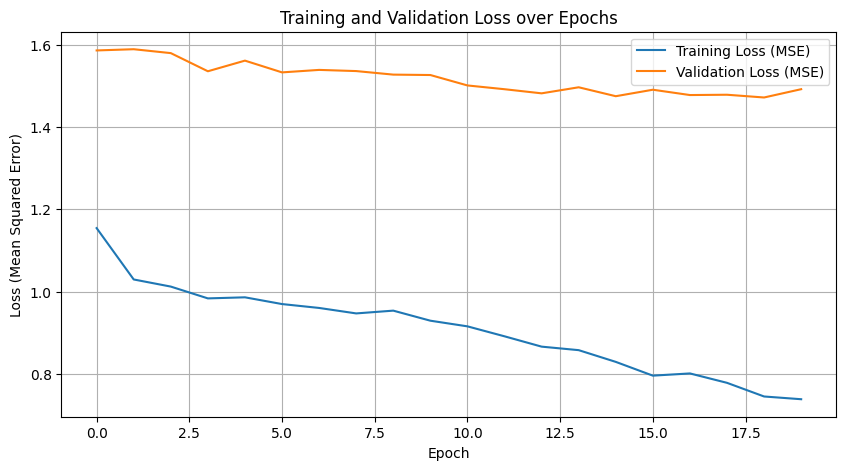


--- Model Summary ---
Model saved to: facial_landmark_detector.pth
Total Parameters: 17306056
Final Training Loss: 0.7382
Final Validation Loss: 1.4921

--- Running Inference on face.jpg ---


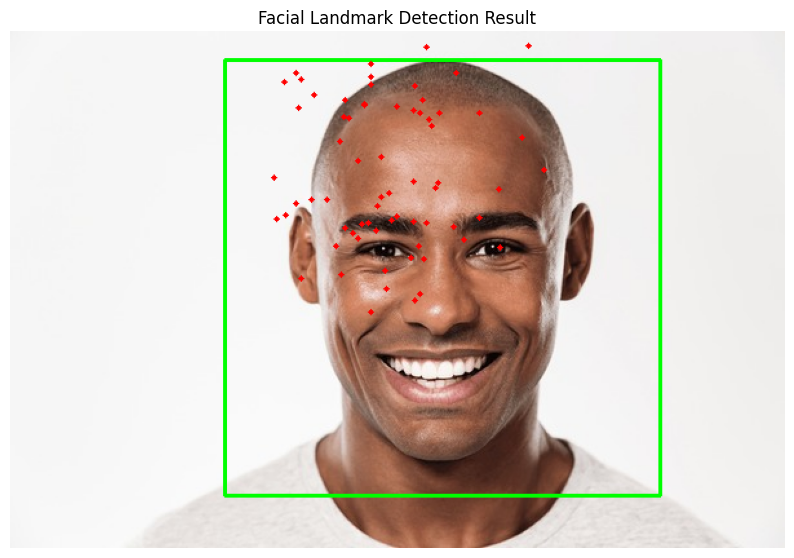

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
import math

# --- CONFIGURATION ---
NUM_LANDMARKS = 68  # Standard 68-point facial landmarks
IMAGE_SIZE = 128    # Input size for the CNN model
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the OpenCV Haar Cascade for face detection
# NOTE: You must have this file downloaded.
# It is usually found in the opencv-contrib-python installation folder.
# Alternatively, you can download it from:
# https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
CASCADE_PATH = 'haarcascade_frontalface_default.xml'

# --- 1. DATA PROCESSING UTILITIES ---

def read_pts_file(filepath):
    """Reads a .pts file and returns a numpy array of landmark coordinates."""
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
            # Find the start of the coordinate data
            start_index = next(i for i, line in enumerate(lines) if line.strip() == '{') + 1
            end_index = next(i for i, line in enumerate(lines) if line.strip() == '}')

            coords = []
            for line in lines[start_index:end_index]:
                x, y = map(float, line.strip().split())
                coords.append([x, y])

        return np.array(coords, dtype=np.float32)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def find_face_and_crop(image, cascade_classifier, padding_scale=1.5):
    """
    Detects the largest face using a Haar Cascade and returns the cropped face image
    and the bounding box.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = cascade_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None, None

    # Get the largest face (x, y, w, h)
    x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

    # Apply padding to the bounding box
    center_x = x + w // 2
    center_y = y + h // 2
    
    # Use the max of w/h for square crop
    max_dim = int(max(w, h) * padding_scale)
    
    new_x = max(0, center_x - max_dim // 2)
    new_y = max(0, center_y - max_dim // 2)
    
    # Calculate the side of the square crop (ensuring it stays within image bounds)
    crop_side = min(max_dim, image.shape[1] - new_x, image.shape[0] - new_y)
    
    face_bbox = (new_x, new_y, crop_side, crop_side)
    
    cropped_face = image[new_y:new_y + crop_side, new_x:new_x + crop_side]

    return cropped_face, face_bbox


# --- 2. CUSTOM PYTORCH DATASET ---

class LandmarkDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_files = glob.glob(os.path.join(image_dir, '*.png')) + glob.glob(os.path.join(image_dir, '*.jpg'))
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.cascade = cv2.CascadeClassifier(CASCADE_PATH)
        self.data_list = []

        # Pre-process and store data references
        for img_path in tqdm(self.image_files, desc="Preprocessing dataset"):
            filename_base = os.path.basename(img_path).rsplit('.', 1)[0]
            pts_path = os.path.join(annotation_dir, filename_base + '.pts')

            if os.path.exists(pts_path):
                image = cv2.imread(img_path)
                if image is None: continue

                landmarks = read_pts_file(pts_path)
                if landmarks is None: continue

                # Find face and crop (important step for landmark detection)
                cropped_face, bbox = find_face_and_crop(image, self.cascade)

                if cropped_face is not None:
                    # Adjust landmarks to be relative to the cropped face bounding box
                    x, y, w, h = bbox
                    relative_landmarks = landmarks - np.array([x, y])
                    
                    # Normalize landmarks (0 to 1 range) relative to the crop dimensions
                    normalized_landmarks = relative_landmarks / np.array([w, h])

                    # Flatten landmarks for model output (2 * NUM_LANDMARKS)
                    flat_landmarks = normalized_landmarks.flatten()

                    self.data_list.append({
                        'img_path': img_path,
                        'cropped_face': cropped_face,
                        'bbox': bbox,
                        'flat_landmarks': flat_landmarks
                    })
    
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        
        image = data['cropped_face']
        landmarks = data['flat_landmarks']
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image to model input size (IMAGE_SIZE)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # Apply transformations (e.g.,ToTensor, normalization)
        if self.transform:
            image_tensor = self.transform(image)
        else:
            # Default transformation: ToTensor and normalize (0-1 range)
            image_tensor = transforms.ToTensor()(image)


        # The model will predict coordinates normalized to the IMAGE_SIZE range,
        # but here we use the 0-1 normalized coordinates for training stability.
        # We also convert landmarks to tensor.
        landmarks_tensor = torch.from_numpy(landmarks).float()

        return image_tensor, landmarks_tensor


# --- 3. PYTORCH MODEL DEFINITION ---

class LandmarkDetector(nn.Module):
    """A simple CNN for regressing facial landmark coordinates."""
    def __init__(self, num_landmarks=NUM_LANDMARKS):
        super(LandmarkDetector, self).__init__()
        
        # The output size is 2 * num_landmarks (x, y for each point)
        self.output_size = 2 * num_landmarks
        
        self.features = nn.Sequential(
            # Input: 3 x IMAGE_SIZE x IMAGE_SIZE (e.g., 3x128x128)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 64 x 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256 x 8 x 8
        )
        
        # Calculate the input size for the fully connected layers
        # 256 channels * 8 * 8 = 16384
        self.fc = nn.Sequential(
            nn.Linear(256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, self.output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


# --- 4. TRAINING FUNCTION ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    """Trains the PyTorch model and tracks loss and accuracy metrics."""
    model.to(DEVICE)
    train_losses = []
    val_losses = []
    
    print(f"\n--- Starting Training on {DEVICE} ---")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for images, landmarks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            images, landmarks = images.to(DEVICE), landmarks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, landmarks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, landmarks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                images, landmarks = images.to(DEVICE), landmarks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, landmarks)
                val_loss += loss.item() * images.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# --- 5. INFERENCE AND VISUALIZATION ---

def predict_landmarks(image_path, model, cascade_classifier):
    """
    Detects face, crops, predicts landmarks, and denormalizes coordinates
    to the original image scale.
    """
    model.eval()
    
    # 1. Load Image
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # 2. Face Detection and Cropping
    cropped_face, bbox = find_face_and_crop(original_image.copy(), cascade_classifier)
    
    if cropped_face is None:
        print("Error: No face detected in the image.")
        return

    # 3. Preprocess for Model Input
    x_orig, y_orig, w_crop, h_crop = bbox
    
    # Resize and convert to tensor
    resized_face = cv2.resize(cropped_face, (IMAGE_SIZE, IMAGE_SIZE))
    resized_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB) # RGB
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        # You can add normalization here if you trained with it
    ])
    
    input_tensor = transform(resized_face).unsqueeze(0).to(DEVICE)

    # 4. Prediction
    with torch.no_grad():
        output = model(input_tensor).cpu().numpy().flatten()
        
    # Reshape the output back to (NUM_LANDMARKS, 2)
    normalized_landmarks_pred = output.reshape(-1, 2)
    
    # 5. Denormalization
    # The output is normalized (0 to 1) relative to the cropped face region
    
    # Scale coordinates by crop size (w_crop, h_crop)
    relative_landmarks = normalized_landmarks_pred * np.array([w_crop, h_crop])
    
    # Shift coordinates by the original face bounding box top-left corner (x_orig, y_orig)
    final_landmarks = relative_landmarks + np.array([x_orig, y_orig])
    
    # 6. Visualization
    result_image = original_image.copy()
    
    # Draw face bounding box
    cv2.rectangle(result_image, (x_orig, y_orig), (x_orig + w_crop, y_orig + h_crop), (0, 255, 0), 2)
    
    # Draw landmarks
    for (x, y) in final_landmarks.astype(np.int32):
        cv2.circle(result_image, (x, y), 2, (0, 0, 255), -1)

    # Display the result (using Matplotlib for Canvas compatibility)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("Facial Landmark Detection Result")
    plt.axis('off')
    plt.show()


def show_results(train_losses, val_losses, model_path, model):
    """Generates and displays performance graphs and model information."""
    
    # 1. Loss Graph
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss (MSE)')
    plt.plot(val_losses, label='Validation Loss (MSE)')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 2. Model Information
    print("\n--- Model Summary ---")
    print(f"Model saved to: {model_path}")
    print(f"Total Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    
    # Note on Accuracy: For regression tasks like landmark detection, "accuracy"
    # is usually measured by metrics like Normalized Mean Error (NME).
    # NME measures the average distance between predicted and ground truth points,
    # normalized by a reference distance (e.g., inter-eye distance or face diagonal).
    # Since we don't have a dedicated test set with the reference metric setup,
    # we rely on the loss as the primary performance indicator here.


# --- 6. MAIN EXECUTION BLOCK ---

def main():
    # --- IMPORTANT: SET YOUR PATHS HERE ---
    # NOTE: You MUST create these folders and populate them with your data.
    IMAGE_DIR = './dataset/images'       # Folder containing your .png or .jpg images
    ANNOTATION_DIR = './dataset/annotations' # Folder containing corresponding .pts files
    TEST_IMAGE_PATH = 'face.jpg' # Path to a single image for demonstration
    MODEL_SAVE_PATH = 'facial_landmark_detector.pth'
    
    # --- 0. Setup and Data Simulation Warning ---
    if not os.path.exists(IMAGE_DIR) or not os.path.exists(ANNOTATION_DIR):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("! WARNING: Data directories not found. Running with SIMULATED DATA. !")
        print("! Please replace the directories below with your actual paths: !")
        print(f"! IMAGE_DIR: {IMAGE_DIR}")
        print(f"! ANNOTATION_DIR: {ANNOTATION_DIR}")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        
        # SIMULATION (Only runs if directories are missing)
        # Create dummy directories and files for demonstration if they don't exist
        os.makedirs(IMAGE_DIR, exist_ok=True)
        os.makedirs(ANNOTATION_DIR, exist_ok=True)
        os.makedirs(os.path.dirname(TEST_IMAGE_PATH), exist_ok=True)
        
        # Create 10 dummy images and annotation files for a minimum runnable dataset
        for i in range(1, 11): # Create 10 samples
            filename_base = f'dummy_{i:03d}'
            img_path = os.path.join(IMAGE_DIR, filename_base + '.jpg')
            pts_path = os.path.join(ANNOTATION_DIR, filename_base + '.pts')
            
            if not os.path.exists(img_path):
                # Create a dummy image with slight variation in size/color
                size = 180 + i * 4 # 184 to 220
                dummy_img = np.ones((size, size, 3), dtype=np.uint8) * (50 + i * 10)
                cv2.putText(dummy_img, filename_base, (10, size // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                cv2.imwrite(img_path, dummy_img)
                
                # Create a dummy .pts file (68 points, centered around center_x, center_y)
                center_x = size // 2
                center_y = size // 2
                with open(pts_path, 'w') as f:
                    f.write('version: 1\n')
                    f.write(f'n_points: {NUM_LANDMARKS}\n')
                    f.write('{\n')
                    # Simulate 68 points forming a rough circle, slightly offset
                    for j in range(NUM_LANDMARKS):
                        x = center_x + 10 * math.cos(j * 2 * math.pi / NUM_LANDMARKS)
                        y = center_y + 10 * math.sin(j * 2 * math.pi / NUM_LANDMARKS)
                        f.write(f'{x:.2f} {y:.2f}\n')
                    f.write('}\n')

        # Also create a dummy test image
        if not os.path.exists(TEST_IMAGE_PATH):
            dummy_test_img = np.ones((300, 300, 3), dtype=np.uint8) * 100
            cv2.putText(dummy_test_img, "TEST IMAGE", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.imwrite(TEST_IMAGE_PATH, dummy_test_img)
        
        # Need to ensure the Haar Cascade file exists for both real and simulated runs
        if not os.path.exists(CASCADE_PATH):
             print(f"\nCRITICAL ERROR: Haar Cascade file not found at {CASCADE_PATH}.")
             print("Please download 'haarcascade_frontalface_default.xml' and place it in the script's directory.")
             return
    # --- END OF SIMULATION ---


    # 1. Initialize Dataset and Dataloaders
    custom_transform = transforms.Compose([
        transforms.ToTensor(),
        # Normalize the image channels to improve training stability
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    full_dataset = LandmarkDataset(IMAGE_DIR, ANNOTATION_DIR, transform=custom_transform)
    
    if len(full_dataset) < 1:
        print("ERROR: Dataset loaded 0 samples. Please check your IMAGE_DIR, ANNOTATION_DIR, and CASCADE_PATH.")
        return
        
    # Split dataset into training (80%) and validation (20%)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Total samples: {len(full_dataset)}")
    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


    # 2. Initialize Model, Loss, and Optimizer
    model = LandmarkDetector(NUM_LANDMARKS)
    # Mean Squared Error (MSE) is the standard loss for regression tasks
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


    # 3. Train the Model
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)


    # 4. Save the Model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nModel saved successfully to {MODEL_SAVE_PATH}")


    # 5. Show Results (Graphs and Metrics)
    show_results(train_losses, val_losses, MODEL_SAVE_PATH, model)


    # 6. Run Inference on a Static Image
    if os.path.exists(TEST_IMAGE_PATH):
        print(f"\n--- Running Inference on {TEST_IMAGE_PATH} ---")
        # Load the saved model for inference
        inference_model = LandmarkDetector(NUM_LANDMARKS)
        inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        inference_model.to(DEVICE)
        
        # Initialize cascade for inference
        inference_cascade = cv2.CascadeClassifier(CASCADE_PATH)
        
        predict_landmarks(TEST_IMAGE_PATH, inference_model, inference_cascade)
    else:
        print(f"Inference skipped: Test image not found at {TEST_IMAGE_PATH}")


if __name__ == '__main__':
    main()


**Changes: using new Dataset**

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
import math

# --- CONFIGURATION ---
NUM_LANDMARKS = 68  # Standard 68-point facial landmarks
IMAGE_SIZE = 128    # Input size for the CNN model
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the OpenCV Haar Cascade for face detection
# NOTE: You must have this file downloaded.
# It is usually found in the opencv-contrib-python installation folder.
# Alternatively, you can download it from:
# https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascades/haarcascade_frontalface_default.xml
CASCADE_PATH = 'haarcascade_frontalface_default.xml'

# --- 1. DATA PROCESSING UTILITIES ---

def find_face_and_crop(image, cascade_classifier, padding_scale=1.5):
    """
    Detects the largest face using a Haar Cascade and returns the cropped face image
    and the bounding box.
    """
    # The input image here is assumed to be a BGR NumPy array
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = cascade_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None, None

    # Get the largest face (x, y, w, h)
    x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

    # Apply padding to the bounding box
    center_x = x + w // 2
    center_y = y + h // 2
    
    # Use the max of w/h for square crop
    max_dim = int(max(w, h) * padding_scale)
    
    new_x = max(0, center_x - max_dim // 2)
    new_y = max(0, center_y - max_dim // 2)
    
    # Calculate the side of the square crop (ensuring it stays within image bounds)
    crop_side = min(max_dim, image.shape[1] - new_x, image.shape[0] - new_y)
    
    face_bbox = (new_x, new_y, crop_side, crop_side)
    
    cropped_face = image[new_y:new_y + crop_side, new_x:new_x + crop_side]

    return cropped_face, face_bbox


# --- 2. CUSTOM PYTORCH DATASET (MODIFIED FOR NPZ/CSV) ---

class LandmarkDataset(Dataset):
    """Loads image data from a .npz file and landmarks from a .csv file."""
    def __init__(self, npz_path, csv_path, transform=None):
        self.transform = transform
        self.cascade = cv2.CascadeClassifier(CASCADE_PATH)
        self.data_list = []

        # Load images from NPZ file
        data = None
        try:
            data = np.load(npz_path)
            
            # Check for the key 'x_train' (common in the linked Kaggle dataset)
            if 'x_train' in data:
                self.images = data['x_train']
                print(f"Using image data from key 'x_train' in {os.path.basename(npz_path)}.")
            # Fallback to the key 'images' (used by the script's simulation)
            elif 'images' in data:
                self.images = data['images']
                print(f"Using image data from key 'images' in {os.path.basename(npz_path)}.")
            else:
                available_keys = list(data.keys())
                data.close() 
                print(f"\nCRITICAL DATASET ERROR: The NPZ file '{os.path.basename(npz_path)}' is missing the required key 'x_train' or 'images'.")
                print(f"The available keys in your file are: {available_keys}")
                raise KeyError(f"Image data not found under expected keys ('x_train' or 'images') in {npz_path}")

        except Exception as e:
            # Handle other loading errors
            print(f"Error loading images from {npz_path}. Ensure the file exists and is a valid NPZ.")
            if data is not None:
                 data.close()
            raise e
        else:
            data.close() # Close the NpzFile object if loading was successful
        
        # Load landmarks from CSV file
        try:
            # Assuming the CSV contains flattened landmarks (N rows, 2*NUM_LANDMARKS columns)
            self.full_landmarks = np.loadtxt(csv_path, delimiter=',', dtype=np.float32)
        except Exception as e:
            print(f"Error loading landmarks from {csv_path}. Ensure the file is correctly formatted.")
            raise e
        
        if len(self.images) != len(self.full_landmarks):
            raise ValueError(f"Image count ({len(self.images)}) does not match landmark count ({len(self.full_landmarks)})")

        # Pre-process: Detect faces, calculate normalized landmarks, and store results
        for i in tqdm(range(len(self.images)), desc="Preprocessing dataset (Face Detection/Crop)"):
            image = self.images[i]
            # Reshape the flattened landmark data (1D array) back to (68, 2)
            landmarks = self.full_landmarks[i].reshape(-1, 2)

            # Find face and crop (important step for landmark detection)
            # We use .copy() because the original image array might be read-only from npz
            cropped_face, bbox = find_face_and_crop(image.copy(), self.cascade)

            if cropped_face is not None:
                x, y, w, h = bbox
                
                # Normalize ground truth landmarks relative to the cropped area
                relative_landmarks = landmarks - np.array([x, y])
                normalized_landmarks = relative_landmarks / np.array([w, h])
                flat_landmarks = normalized_landmarks.flatten()

                # Store the index of the image/landmark pair and the calculated preprocessing results
                self.data_list.append({
                    'index': i,
                    'bbox': bbox,
                    'flat_landmarks': flat_landmarks
                })
    
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        original_idx = data['index']
        
        # Access the image array directly using the stored index
        image = self.images[original_idx].copy() 
        x_orig, y_orig, w_crop, h_crop = data['bbox']
        landmarks = data['flat_landmarks']
        
        # Crop the image using the pre-calculated bounding box
        cropped_face = image[y_orig:y_orig + h_crop, x_orig:x_orig + w_crop]
        
        # Convert BGR (assuming data is loaded in BGR from cv2-like source) to RGB
        image_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

        # Resize image to model input size (IMAGE_SIZE)
        image_resized = cv2.resize(image_rgb, (IMAGE_SIZE, IMAGE_SIZE))

        # Apply transformations
        image_tensor = self.transform(image_resized)

        # Convert landmarks to tensor
        landmarks_tensor = torch.from_numpy(landmarks).float()

        return image_tensor, landmarks_tensor


# --- 3. PYTORCH MODEL DEFINITION ---

class LandmarkDetector(nn.Module):
    """A simple CNN for regressing facial landmark coordinates."""
    def __init__(self, num_landmarks=NUM_LANDMARKS):
        super(LandmarkDetector, self).__init__()
        
        # The output size is 2 * num_landmarks (x, y for each point)
        self.output_size = 2 * num_landmarks
        
        self.features = nn.Sequential(
            # Input: 3 x IMAGE_SIZE x IMAGE_SIZE (e.g., 3x128x128)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 64 x 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256 x 8 x 8
        )
        
        # Calculate the input size for the fully connected layers
        # 256 channels * 8 * 8 = 16384
        self.fc = nn.Sequential(
            nn.Linear(256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, self.output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


# --- 4. TRAINING FUNCTION ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    """Trains the PyTorch model and tracks loss and accuracy metrics."""
    model.to(DEVICE)
    train_losses = []
    val_losses = []
    
    print(f"\n--- Starting Training on {DEVICE} ---")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for images, landmarks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            images, landmarks = images.to(DEVICE), landmarks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, landmarks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, landmarks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                images, landmarks = images.to(DEVICE), landmarks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, landmarks)
                val_loss += loss.item() * images.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# --- 5. INFERENCE AND VISUALIZATION ---

def predict_landmarks(image_path, model, cascade_classifier):
    """
    Detects face, crops, predicts landmarks, and denormalizes coordinates
    to the original image scale.
    """
    model.eval()
    
    # 1. Load Image
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # 2. Face Detection and Cropping
    cropped_face, bbox = find_face_and_crop(original_image.copy(), cascade_classifier)
    
    if cropped_face is None:
        print("Error: No face detected in the image.")
        return

    # 3. Preprocess for Model Input
    x_orig, y_orig, w_crop, h_crop = bbox
    
    # Resize and convert to tensor
    resized_face = cv2.resize(cropped_face, (IMAGE_SIZE, IMAGE_SIZE))
    resized_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB) # RGB
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        # You can add normalization here if you trained with it
    ])
    
    input_tensor = transform(resized_face).unsqueeze(0).to(DEVICE)

    # 4. Prediction
    with torch.no_grad():
        output = model(input_tensor).cpu().numpy().flatten()
        
    # Reshape the output back to (NUM_LANDMARKS, 2)
    normalized_landmarks_pred = output.reshape(-1, 2)
    
    # 5. Denormalization
    # The output is normalized (0 to 1) relative to the cropped face region
    
    # Scale coordinates by crop size (w_crop, h_crop)
    relative_landmarks = normalized_landmarks_pred * np.array([w_crop, h_crop])
    
    # Shift coordinates by the original face bounding box top-left corner (x_orig, y_orig)
    final_landmarks = relative_landmarks + np.array([x_orig, y_orig])
    
    # 6. Visualization
    result_image = original_image.copy()
    
    # Draw face bounding box
    cv2.rectangle(result_image, (x_orig, y_orig), (x_orig + w_crop, y_orig + h_crop), (0, 255, 0), 2)
    
    # Draw landmarks
    for (x, y) in final_landmarks.astype(np.int32):
        cv2.circle(result_image, (x, y), 2, (0, 0, 255), -1)

    # Display the result (using Matplotlib for Canvas compatibility)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("Facial Landmark Detection Result")
    plt.axis('off')
    plt.show()


def show_results(train_losses, val_losses, model_path, model):
    """Generates and displays performance graphs and model information."""
    
    # 1. Loss Graph
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss (MSE)')
    plt.plot(val_losses, label='Validation Loss (MSE)')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 2. Model Information
    print("\n--- Model Summary ---")
    print(f"Model saved to: {model_path}")
    print(f"Total Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    
    # Note on Accuracy: For regression tasks like landmark detection, "accuracy"
    # is usually measured by metrics like Normalized Mean Error (NME).
    # NME measures the average distance between predicted and ground truth points,
    # normalized by a reference distance (e.g., inter-eye distance or face diagonal).
    # Since we don't have a dedicated test set with the reference metric setup,
    # we rely on the loss as the primary performance indicator here.


# --- 6. MAIN EXECUTION BLOCK (MODIFIED FOR NPZ/CSV) ---

def main():
    # --- IMPORTANT: SET YOUR PATHS HERE ---
    # NOTE: You MUST replace these paths with your actual dataset files.
    DATA_NPZ_PATH = './dataset/face_images.npz'         # File containing your image arrays
    DATA_CSV_PATH = './dataset/face_keypoints.csv'    # File containing your landmark coordinates
    TEST_IMAGE_PATH = 'face.jpg' # Path to a single image for demonstration
    MODEL_SAVE_PATH = 'facial_landmark_detector.pth'
    
    # --- 0. Setup and Data Simulation Warning ---
    if not os.path.exists('./dataset'):
        os.makedirs('./dataset', exist_ok=True)
        os.makedirs(os.path.dirname(TEST_IMAGE_PATH), exist_ok=True)

    if not os.path.exists(DATA_NPZ_PATH) or not os.path.exists(DATA_CSV_PATH):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("! WARNING: Data files not found. Running with SIMULATED DATA. !")
        print("! Please replace the paths below with your actual dataset files: !")
        print(f"! DATA_NPZ_PATH: {DATA_NPZ_PATH}")
        print(f"! DATA_CSV_PATH: {DATA_CSV_PATH}")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        
        # SIMULATION (Only runs if files are missing)
        N_SAMPLES = 10
        H, W = 200, 200 # Dummy image size
        
        # 1. Simulate Image Data (.npz)
        # Create N dummy images (BGR format assumed for cv2 compatibility)
        dummy_images = []
        for i in range(N_SAMPLES):
            # Create a dummy image with slight variation in size/color
            dummy_img = np.ones((H, W, 3), dtype=np.uint8) * (50 + i * 10)
            cv2.putText(dummy_img, f"Sample {i+1}", (10, H // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            dummy_images.append(dummy_img)
        
        # NOTE: The key used here for simulation is 'images', matching the code's expectation.
        np.savez_compressed(DATA_NPZ_PATH, images=np.array(dummy_images))
        
        # 2. Simulate Landmark Data (.csv)
        # Create N rows of 2*NUM_LANDMARKS coordinates
        dummy_landmarks = []
        center_x, center_y = W // 2, H // 2
        for i in range(N_SAMPLES):
            landmarks = []
            # Simulate 68 points forming a rough circle, slightly offset per sample
            for j in range(NUM_LANDMARKS):
                x = center_x + (10 + i) * math.cos(j * 2 * math.pi / NUM_LANDMARKS)
                y = center_y + (10 + i) * math.sin(j * 2 * math.pi / NUM_LANDMARKS)
                landmarks.extend([x, y])
            dummy_landmarks.append(landmarks)
            
        np.savetxt(DATA_CSV_PATH, np.array(dummy_landmarks), delimiter=',', fmt='%.2f')

        # 3. Create a dummy test image (if missing)
        if not os.path.exists(TEST_IMAGE_PATH):
            dummy_test_img = np.ones((300, 300, 3), dtype=np.uint8) * 100
            cv2.putText(dummy_test_img, "TEST IMAGE", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.imwrite(TEST_IMAGE_PATH, dummy_test_img)
        
        # Ensure the Haar Cascade file exists for both real and simulated runs
        if not os.path.exists(CASCADE_PATH):
             print(f"\nCRITICAL ERROR: Haar Cascade file not found at {CASCADE_PATH}.")
             print("Please download 'haarcascade_frontalface_default.xml' and place it in the script's directory.")
             return
    # --- END OF SIMULATION ---


    # 1. Initialize Dataset and Dataloaders
    custom_transform = transforms.Compose([
        transforms.ToTensor(),
        # Normalize the image channels to improve training stability
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Initialize the modified Dataset class with NPZ and CSV paths
    full_dataset = LandmarkDataset(DATA_NPZ_PATH, DATA_CSV_PATH, transform=custom_transform)
    
    if len(full_dataset) < 1:
        print("ERROR: Dataset loaded 0 samples. Please check your data paths and CASCADE_PATH.")
        return
        
    # Split dataset into training (80%) and validation (20%)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Total samples: {len(full_dataset)}")
    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


    # 2. Initialize Model, Loss, and Optimizer
    model = LandmarkDetector(NUM_LANDMARKS)
    # Mean Squared Error (MSE) is the standard loss for regression tasks
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


    # 3. Train the Model
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)


    # 4. Save the Model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nModel saved successfully to {MODEL_SAVE_PATH}")


    # 5. Show Results (Graphs and Metrics)
    show_results(train_losses, val_losses, MODEL_SAVE_PATH, model)


    # 6. Run Inference on a Static Image
    if os.path.exists(TEST_IMAGE_PATH):
        print(f"\n--- Running Inference on {TEST_IMAGE_PATH} ---")
        # Load the saved model for inference
        inference_model = LandmarkDetector(NUM_LANDMARKS)
        inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        inference_model.to(DEVICE)
        
        # Initialize cascade for inference
        inference_cascade = cv2.CascadeClassifier(CASCADE_PATH)
        
        predict_landmarks(TEST_IMAGE_PATH, inference_model, inference_cascade)
    else:
        print(f"Inference skipped: Test image not found at {TEST_IMAGE_PATH}")


if __name__ == '__main__':
    main()


Using image data from key 'images' in face_images.npz.


Preprocessing dataset (Face Detection/Crop): 100%|████████████████████████████████████| 10/10 [00:00<00:00, 326.04it/s]

ERROR: Dataset loaded 0 samples. Please check your data paths and CASCADE_PATH.


<hr>

**New Code from : Kaggle**: *Uses Tensorflow*

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [63]:
# Ploting images with landmarks
def plot_image_landmarks(img_array, df_landmarks, index):
    plt.imshow(img_array[index, :, :, 0], cmap = 'gray')
    plt.scatter(df_landmarks.iloc[index][0: -1: 2], df_landmarks.iloc[index][1: : 2], c = 'y')
    plt.show()

In [68]:
features = np.load('./dataset/face_images.npz')
features = features.get(features.files[0]) # images
features = np.moveaxis(features, -1, 0)

features = features.reshape(features.shape[0], features.shape[1], features.shape[1], 1)

ValueError: cannot reshape array of size 1200000 into shape (3,10,10,1)

In [57]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam

In [58]:
img_size = 96
model = Sequential()

model.add(Input(shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))  

model.add(Flatten())
model.add(Dense(256,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5)) 

model.add(Dense(64,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0))

model.add(Dense(30,kernel_initializer=glorot_uniform()))

model.summary()
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy'])

C:\Users\akash\Music\fld\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 96, 96, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,4

 Total params: 4,830,306 (18.43 MB)

 Trainable params: 4,830,112 (18.43 MB)

 Non-trainable params: 194 (776.00 B)

In [59]:
BATCH_SIZE = 100
EPOCHS = 150

In [ ]:
#training

In [60]:
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1,
)

NameError: name 'x_train' is not defined

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Facial keypoints')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# plt.plot(history.history['mean_squared_error'], label='MSE (training data)')
# plt.plot(history.history['val_mean_squared_error'], label='MSE (validation data)')
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('MSE for Facial keypoints')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#evaluation

In [ ]:
y_pred = model.predict(x_test)
y_pred

In [ ]:
def plot_img_preds(images, truth, pred, index):
    plt.imshow(images[index, :, :, 0], cmap = 'gray')
    
    t = np.array(truth)[index]
    plt.scatter(t[0::2], t[1::2], c = 'y')
    
    p = pred[index, :]
    plt.scatter(p[0::2], p[1::2], c = 'r')
    
    plt.show()